# Standardiser Bug

In [1]:
pwd

'/home/francis/projects/tox_models'

In [2]:
%run ~/data/notebooks/setup.py

Loading BokehJS ...

In [3]:
from chembl_webresource_client import CompoundResource

In [4]:
from standardiser import standardise, break_bonds, unsalt, neutralise, rules

from standardiser.utils import StandardiseException

In [5]:
import make_logger

from rdkit_utils import FP

In [6]:
logger = make_logger.run(__name__)

In [7]:
cmpd_resource = CompoundResource()

get_smiles = lambda chembl_id:  cmpd_resource.get(chembl_id)['smiles']

In [8]:
# standardise.verbose()

## Example

In [9]:
chembl_id = 'CHEMBL6828'

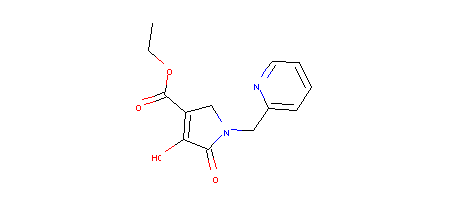

In [10]:
mol = Chem.MolFromSmiles(get_smiles(chembl_id))

mol

### Bug

* Rule '[Enol -> Ketone](http://wwwdev.ebi.ac.uk/chembl/extra/francis/standardiser/03_rules.html#Enol_-_Ketone)' not applied as expected

* RDKit gives unexpected valeny error

RDKit ERROR: [12:42:38] Explicit valence for atom # 0 O, 3, is greater than permitted


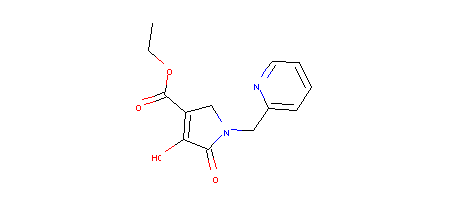

In [11]:
standardise.run(mol)

`rules` module works as expected...

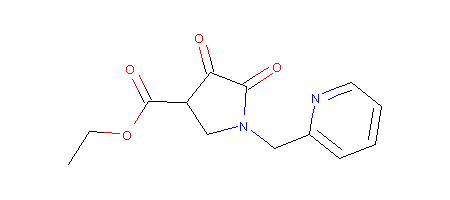

In [12]:
rules.run(mol)

`break_bonds` + `rules` works as expected...

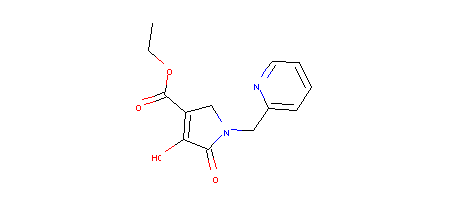

In [13]:
mol1 = break_bonds.run(mol)

mol1

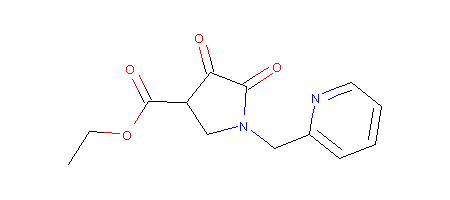

In [14]:
rules.run(mol1)

`neutralise` + `rules` exhibits bug...

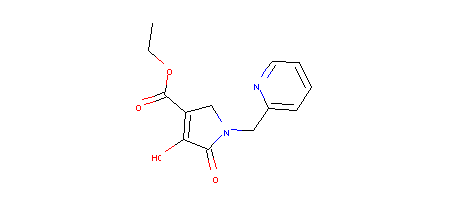

In [15]:
mol2 = neutralise.run(mol)

mol2

RDKit ERROR: [12:42:38] Explicit valence for atom # 0 O, 3, is greater than permitted


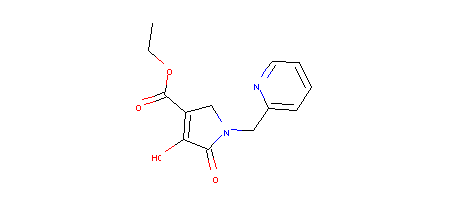

In [16]:
rules.run(mol2)

Thus, the `neutralize` module gives a molecule that renders OK but is somehow not quite right.

### Simplify

Do reaction step only...

In [17]:
smarts = '[OH:1][C:2]=[C:3]>>[O:1]=[C:2][C:3]'

rxn = AllChem.ReactionFromSmarts(smarts)

Original mol OK...

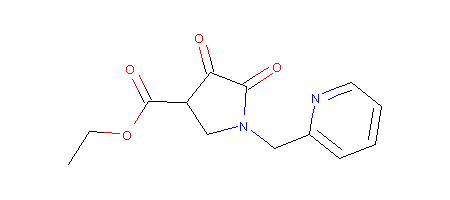

In [18]:
rxn.RunReactants((mol,))[0][0]

Mol after `break_bonds` OK...

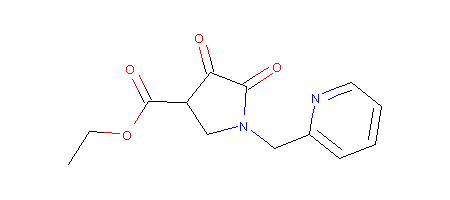

In [19]:
rxn.RunReactants((mol1,))[0][0]

Mol after `neutralise` _not_ OK...

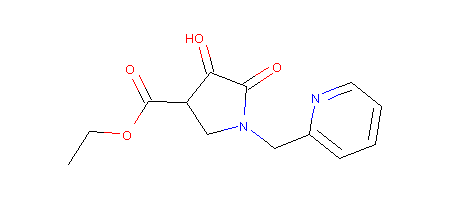

In [20]:
mol3 = rxn.RunReactants((mol2,))[0][0]

mol3

Mol produced can be rendered but _not_ sanitised...

In [21]:
try: 
    Chem.SanitizeMol(mol3)
except ValueError as err:
    logger.error(err)

RDKit ERROR: [12:42:38] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 174 in file /home/rdkit/miniconda/conda-bld/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [12:42:38] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 174 in file /home/rdkit/miniconda/conda-bld/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [12:42:38] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 174 in file /home/rdkit/miniconda/conda-bld

### Minimal test case...

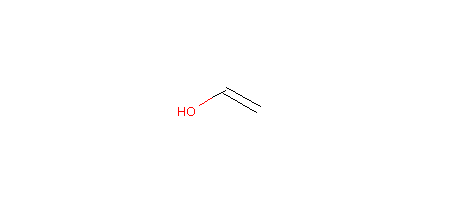

In [22]:
test = Chem.MolFromSmiles('OC=C')

test

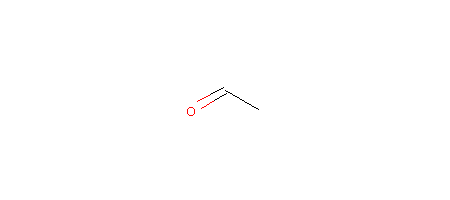

In [23]:
rxn.RunReactants((test,))[0][0]

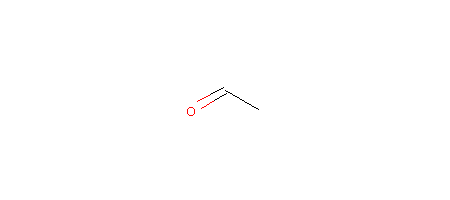

In [24]:
rxn.RunReactants((break_bonds.run(test),))[0][0]

Problem occurs with simplest possible test case...

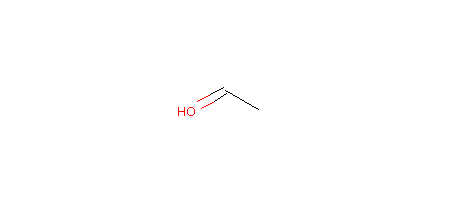

In [25]:
rxn.RunReactants((neutralise.run(test),))[0][0]

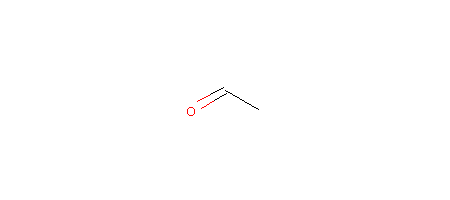

In [26]:
# smarts = '[OH:1][C:2]=[C:3]>>[O:1]=[C:2][C:3]'

smarts2 = '[OH:1][C:2]=[C:3]>>[OH0:1]=[C:2][C:3]'

rxn2 = AllChem.ReactionFromSmarts(smarts2)

rxn2.RunReactants((neutralise.run(test),))[0][0]